## Imports

In [1]:
from JSU_lib import *

In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import time 
import colorsys

import warnings
import logging
warnings.filterwarnings('ignore') # ignores warnings
logging.disable(logging.CRITICAL) # disables logging

from Bio.PDB import PDBParser, MMCIFParser, Selection
from prointvar.pdbx import PDBXreader

## Functions

## Setting directories

In [2]:
target_dir = './../DATA/rep_chains'
preds_dir = "./results/IFSP_preds"
targets = [el for el in os.listdir(target_dir) if el.endswith(".pdb")]

In [3]:
len(os.listdir(preds_dir))

4437

In [4]:
len(targets)

4435

In [5]:
LIGYSIS_reps = read_from_pickle("./results/LIGYSIS_3448_chains.pkl")
len(set(LIGYSIS_reps).intersection(set([el.split(".")[0] for el in targets])))

3448

## Extract pocket data and create IFSP pockets DF

In [6]:
i = 0
for i, target in enumerate(targets):
    target_id = target.split(".")[0]
    prediction_dir = os.path.join(preds_dir, target_id)
    files = os.listdir(prediction_dir)
    sites_files = [f for f in files if f.startswith("site_rank")]
    centres_files = [f for f in files if f.startswith("centre_rank")]

In [7]:
dfs = []
for i, target in enumerate(targets):
    if i % 50 == 0:
        print(i)
    target_id = target.split(".")[0]
    prediction_dir = os.path.join(preds_dir, target_id)
    files = os.listdir(prediction_dir)
    sites_files = [f for f in files if f.startswith("site_rank")]
    centres_files = [f for f in files if f.startswith("centre_rank")]

    pdb_path = os.path.join(target_dir, target)
    parser = PDBParser()
    structure = parser.get_structure('structure', pdb_path)

    centre_coords = {}
    ranks = {}
    for f in centres_files:
        r = os.path.splitext(f)[0].split("_")[-1]
        rank = int(r)
        ranks[rank] = rank
        centre_coords[rank] = extract_coordinates(os.path.join(prediction_dir, f))

    residues = {}
    n_points = {}
    for f in sites_files:
        r = os.path.splitext(f)[0].split("_")[-1]
        rank = int(r)
        ranks[rank] = rank
        site_file_path = os.path.join(prediction_dir, f)
        #print(site_file_path)
        site_coords = extract_multiple_coordinates(site_file_path)
        n_points[rank] = len(site_coords)
        un_coords = list(set(site_coords))
        #print(un_coords)
        residues[rank] = find_residues_near_points(
            structure,
            un_coords,
            6.0
        )

    data = {'rank': ranks, 'centre': centre_coords, 'n_points': n_points, 'aas': residues}

    # Create DataFrame
    df = pd.DataFrame.from_dict(data)

    df["rep_chain"] = target_id
    df["n_aas"] = df['aas'].apply(lambda x: len(x)) 

    df = df[["rep_chain", "rank", "n_points", "n_aas", "centre", "aas"]]
    dfs.append(df)

0
50
100
  198 A
150
  164 C
  136 D
  136 D
  137 E
  137 E
  137 E
  137 E
  137 E
  137 E
  138 F
  138 F
  138 F
  138 F
  138 F
  138 F
  138 F
  169 H
  43 A
  44 B
  44 B
  47 E
  47 E
  47 E
  133 A
  133 A
  133 A
  133 A
  134 B
  134 B
  134 B
  134 B
  134 B
  134 B
  134 B
  135 C
  135 C
  165 D
  165 D
  165 D
  165 D
  166 E
  166 E
  166 E
  166 E
  166 E
  166 E
  169 H
  169 H
  169 H
  169 H
  169 H
  169 H
  169 H
  169 H
  170 I
  171 J
  171 J
  171 J
  171 J
  171 J
  171 J
  171 J
  171 J
  171 J
  171 J
  88 J
  88 J
  88 J
  88 J
  212 A
  88 J
  88 J
  88 J
  88 J
  22 A
  22 A
  22 A
  22 A
  22 A
  22 A
  22 A
  22 A
  22 A
  22 A
  23 B
  23 B
  23 B
  23 B
  23 B
200
250
  85 B
  85 B
  191 A
  191 A
  191 A
  191 A
  191 A
300
350
400
450
  179 A
  179 A
  179 A
  179 A
  217 A
  217 A
  217 A
  217 A
  184 A
  184 A
  217 A
  217 A
  217 A
  217 A
  217 A
  169 I
  169 I
  169 I
  162 B
  162 B
  168 H
  168 H
  168 H
  168 H
  169 I
  169 I
  169 I
  

In [8]:
len([df for df in dfs if not df.empty]) # 3343

3343

In [9]:
len([df for df in dfs if  df.empty]) #1092

1092

In [10]:
pockets_df = pd.concat([df for df in dfs if not df.empty]).sort_values(["rep_chain", "rank"]).reset_index(drop=True)

In [11]:
pockets_df.to_pickle("./results/IFSP_pockets_6A.pkl")

In [13]:
#pockets_df = pd.read_pickle("./results/IFSP_pockets.pkl")

In [12]:
pockets_df.rename(columns = {'rank': 'RANK'}, inplace = True)

In [13]:
pockets_df.head(3)

,rep_chain,RANK,n_points,n_aas,centre,aas
0,1a52_A,1,50,18,"(106.965, 17.341, 98.538)","[108, 128, 129, 132, 49, 50, 51, 53, 54, 55, 5..."
1,1a52_A,2,16,10,"(107.392, 11.041, 96.198)","[125, 225, 228, 229, 232, 46, 47, 50, 51, 54]"
2,1a52_A,3,14,8,"(105.276, 12.648, 98.448)","[229, 47, 50, 51, 54, 87, 88, 91]"


In [14]:
len(set(LIGYSIS_reps).intersection(set(pockets_df.rep_chain.unique()))) #2502

2502

In [15]:
len([len(el) for el in dfs if len(el) == 0]) #1092

1092

In [16]:
#no_sites = read_from_pickle("./results/IFSP_no_site_accs_V2.pkl")

In [16]:
site_targets = pockets_df.rep_chain.unique().tolist()

In [17]:
len(site_targets) #3343

3343

In [20]:
cc = [
    'label_seq_id_full', 'label_comp_id', 'type_symbol',
    'label_atom_id', 'Cartn_x', 'Cartn_y', 'Cartn_z'
]

## Calculate RoG of IFSP pockets

In [21]:
T0 = time.time()
RoG_dict = {}
centres_dict_ress = {}
for i, target in enumerate(site_targets):
    if i % 500 == 0:
        print(i)
    pdb_path = os.path.join(trans_rep_chains_dir, f'{target}.trans.pdb') #using transformed structure for new centre and RoG
    df = PDBXreader(inputfile=pdb_path).atoms(format_type="pdb", excluded=())[cc].query('label_atom_id == "CA"').reset_index(drop = True)
    #df.label_seq_id = df.label_seq_id_full.astype(int)
    target_sites_df = pockets_df.query('rep_chain == @target')
    #print(len(acc_sites_df))
    for _, row in target_sites_df.iterrows():
        site_ress = row.aas
        site_ress = [str(el) for el in site_ress]
        if site_ress == []:
            RoG_dict[(target, row.ID)] = np.nan
            continue
        #print(site_ress)
        #print(site_ress)
        ress_CAs = df.query('label_seq_id_full in @site_ress')
        CAs_coords = np.array(list((zip(ress_CAs.Cartn_x, ress_CAs.Cartn_y, ress_CAs.Cartn_z))))
        center_of_mass = np.mean(CAs_coords, axis=0)
        distances_squared = np.sum((CAs_coords - center_of_mass)**2, axis=1)
        radius_of_gyration = round(np.sqrt(np.mean(distances_squared)), 2)
        RoG_dict[(target, row["RANK"])] = radius_of_gyration
        centres_dict_ress[(target, row["RANK"])] = tuple([round(v, 3) for v in center_of_mass])
        #break
    #break
TF = time.time()

0
500
1000
1500
2000
2500
3000


In [22]:
dTs = TF-T0

dTm = dTs/60

N_RoG = len(RoG_dict)

print(N_RoG)

print(round(dTm,2))

print(round(dTs/N_RoG, 5))

69581
5.23
0.00451


In [23]:
round((N_RoG*(dTs/N_RoG))/60, 2) # 5.8 minutes

5.23

In [84]:
#save_to_pickle(RoG_dict, "./results/RoG_IFSP_pockets_V2_6A_labfull.pkl")

In [24]:
pockets_df["ID"] = pockets_df["RANK"]

In [25]:
pockets_df["RoG"] = pockets_df.set_index(['rep_chain', 'RANK']).index.map(RoG_dict)

In [26]:
pockets_df["centre_trans"] = np.nan
centres = []
errs = 0
err_chains = []
for i, row in pockets_df.iterrows():
    try:
        centre = centres_dict_ress[(row.rep_chain, row.RANK)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
        err_chains.append(row.rep_chain)
print(errs) # 599

0


In [27]:
pockets_df["centre_trans"] = centres

In [28]:
pockets_df.head(3)

,rep_chain,RANK,n_points,n_aas,centre,aas,ID,RoG,centre_trans
0,1a52_A,1,50,18,"(106.965, 17.341, 98.538)","[108, 128, 129, 132, 49, 50, 51, 53, 54, 55, 5...",1,8.22,"(2.382, -7.114, 1.517)"
1,1a52_A,2,16,10,"(107.392, 11.041, 96.198)","[125, 225, 228, 229, 232, 46, 47, 50, 51, 54]",2,6.95,"(-0.328, -14.296, -2.677)"
2,1a52_A,3,14,8,"(105.276, 12.648, 98.448)","[229, 47, 50, 51, 54, 87, 88, 91]",3,6.99,"(-1.693, -9.656, 0.425)"


In [29]:
pockets_df.to_pickle("./results/IFSP_RoG_6A_TRANS.pkl")

## Translating and rotating IF-SitePred predicted centroid

In [38]:
import importlib
import JSU_lib
importlib.reload(JSU_lib)
from JSU_lib import *

In [39]:
pockets_df['centre_mat'] = pockets_df.apply(apply_rotation, axis=1)
pockets_df['distance'] = pockets_df.apply(calculate_distance, axis=1)

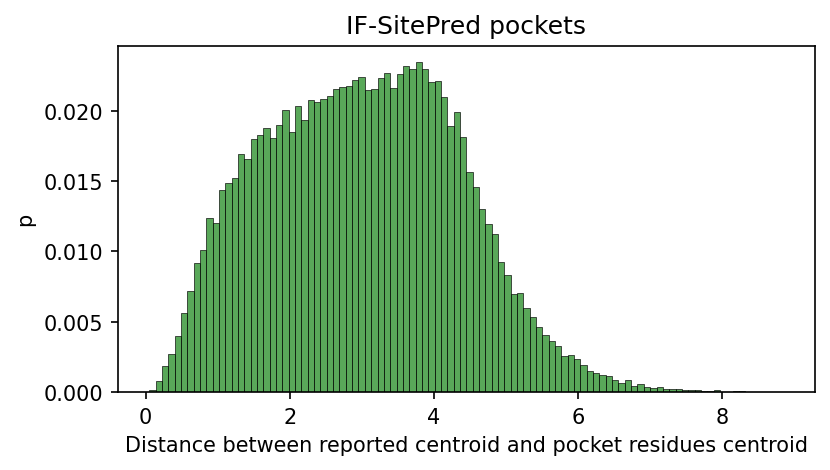

In [41]:
plt.figure(figsize = (6,3), dpi = 150)

sns.histplot(pockets_df.distance, bins = 100, stat = "proportion", color = "forestgreen")
#plt.xlim(-30, 20)
plt.title("IF-SitePred pockets")
plt.xlabel("Distance between reported centroid and pocket residues centroid")
plt.ylabel("p")
plt.show()

## Mapping PDB residues to UP residues

In [42]:
up_aas = {}

errors = []

no_sifts = []
for _, row in pockets_df.iterrows():
    b = 0
    rep_chain = row.rep_chain
    if rep_chain in no_sifts:
        continue
    site_ress = row.aas
    rank = row["RANK"]
    try:
        mapping_dict = read_from_pickle(f'./../DATA/mappings_label/{rep_chain}.pkl')
    except:
        print(f'SIFTS file not found for {rep_chain}')
        no_sifts.append(rep_chain)
        
    site_up_aas = []
    for res in site_ress:
        try:
            site_up_aas.append(mapping_dict[str(res)]) # I think there are integers here as it is not working with AltLocs, so none are present
        except:
            errors.append(rep_chain)
            b = 1
            break
    if b ==1:
        continue
    up_aas[(rep_chain, rank)] = site_up_aas

In [43]:
len(up_aas) #69124

69124

In [44]:
errors = list(set(errors)) # 36 chains have issues with SIFTS mapping, e.g, 1nav_A. For some reason, the last 40 residues lack residue mapping to UniProt, 119 pockets
print(len(errors)) #136

136


In [45]:
save_to_pickle(errors, "./results/IFSP_no_sifts_TRANS.pkl")

In [46]:
pockets_df_w_sifts = pockets_df.query('rep_chain not in @errors').copy().reset_index(drop = True)

In [47]:
pockets_df_w_sifts["up_aas"] = pockets_df_w_sifts.set_index(['rep_chain', 'RANK']).index.map(up_aas)

In [48]:
pockets_df_w_sifts["n_up_aas"] = pockets_df_w_sifts['up_aas'].apply(lambda x: len(x)) 

In [49]:
pockets_df_w_sifts.n_aas.equals(pockets_df_w_sifts.n_up_aas)

True

In [50]:
pockets_df_w_sifts.drop(columns = ["n_up_aas"], inplace = True)

In [51]:
pockets_df_w_sifts.head(5)

,rep_chain,RANK,n_points,n_aas,centre,aas,ID,RoG,centre_trans,centre_mat,distance,up_aas
0,1a52_A,1,50,18,"(106.965, 17.341, 98.538)","[108, 128, 129, 132, 49, 50, 51, 53, 54, 55, 5...",1,8.22,"(2.382, -7.114, 1.517)","(2.147, -7.804, 1.049)",0.866227,"[404, 424, 425, 428, 345, 346, 347, 349, 350, ..."
1,1a52_A,2,16,10,"(107.392, 11.041, 96.198)","[125, 225, 228, 229, 232, 46, 47, 50, 51, 54]",2,6.95,"(-0.328, -14.296, -2.677)","(0.017, -13.242, -2.305)",1.169754,"[421, 521, 524, 525, 528, 342, 343, 346, 347, ..."
2,1a52_A,3,14,8,"(105.276, 12.648, 98.448)","[229, 47, 50, 51, 54, 87, 88, 91]",3,6.99,"(-1.693, -9.656, 0.425)","(-1.486, -11.034, -0.071)",1.479104,"[525, 343, 346, 347, 350, 383, 384, 387]"
3,1a52_A,4,12,10,"(105.33, 5.416, 98.073)","[228, 229, 230, 231, 232, 233, 236, 47, 48, 51]",4,6.25,"(-4.015, -17.087, -4.334)","(-4.745, -17.29, -1.715)",2.726402,"[524, 525, 526, 527, 528, 529, 532, 343, 344, ..."
4,1a52_A,5,9,13,"(106.955, 13.041, 92.448)","[124, 125, 128, 132, 221, 224, 225, 226, 228, ...",5,7.26,"(1.022, -9.619, -6.964)","(1.283, -10.927, -5.665)",1.861823,"[420, 421, 424, 428, 517, 520, 521, 522, 524, ..."


In [52]:
len(pockets_df_w_sifts) #67269

67269

In [53]:
len(pockets_df_w_sifts.rep_chain.unique()) #3207

3207

In [55]:
len(set(LIGYSIS_reps).intersection(set(pockets_df_w_sifts.rep_chain.unique()))) #2393

2393

In [107]:
#pockets_df_w_sifts.to_pickle("./results/IFSP_pockets_sifted_V2_6A_labfull.pkl")

## Add pocket surfaces and volumes

In [56]:

#pockets_df_w_sifts = pd.read_pickle("./results/IFSP_pockets_sifted_V2_6A_labfull.pkl")

master_SASA_dict = read_from_pickle("./results/master_SASA_dict.pkl")

pockets_df_w_sifts_SASA = calculate_total_sasa(pockets_df_w_sifts, master_SASA_dict)

vols_dict = read_from_pickle("./results/IFSP_volumes_dict.pkl")

pockets_df_w_sifts_SASA["VOL"] = pockets_df_w_sifts_SASA.set_index(['rep_chain', 'ID']).index.map(vols_dict)

pockets_df_w_sifts_SASA.query('VOL != VOL')

,rep_chain,RANK,n_points,n_aas,centre,aas,ID,RoG,centre_trans,centre_mat,distance,up_aas,SASA,VOL


In [57]:
pockets_df_w_sifts_SASA

,rep_chain,RANK,n_points,n_aas,centre,aas,ID,RoG,centre_trans,centre_mat,distance,up_aas,SASA,VOL
0,1a52_A,1,50,18,"(106.965, 17.341, 98.538)","[108, 128, 129, 132, 49, 50, 51, 53, 54, 55, 5...",1,8.22,"(2.382, -7.114, 1.517)","(2.147, -7.804, 1.049)",0.866227,"[404, 424, 425, 428, 345, 346, 347, 349, 350, ...",390.21,488
1,1a52_A,2,16,10,"(107.392, 11.041, 96.198)","[125, 225, 228, 229, 232, 46, 47, 50, 51, 54]",2,6.95,"(-0.328, -14.296, -2.677)","(0.017, -13.242, -2.305)",1.169754,"[421, 521, 524, 525, 528, 342, 343, 346, 347, ...",201.38,277
2,1a52_A,3,14,8,"(105.276, 12.648, 98.448)","[229, 47, 50, 51, 54, 87, 88, 91]",3,6.99,"(-1.693, -9.656, 0.425)","(-1.486, -11.034, -0.071)",1.479104,"[525, 343, 346, 347, 350, 383, 384, 387]",237.54,353
3,1a52_A,4,12,10,"(105.33, 5.416, 98.073)","[228, 229, 230, 231, 232, 233, 236, 47, 48, 51]",4,6.25,"(-4.015, -17.087, -4.334)","(-4.745, -17.29, -1.715)",2.726402,"[524, 525, 526, 527, 528, 529, 532, 343, 344, ...",565.05,221
4,1a52_A,5,9,13,"(106.955, 13.041, 92.448)","[124, 125, 128, 132, 221, 224, 225, 226, 228, ...",5,7.26,"(1.022, -9.619, -6.964)","(1.283, -10.927, -5.665)",1.861823,"[420, 421, 424, 428, 517, 520, 521, 522, 524, ...",338.45,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67264,8yhh_B,20,3,4,"(13.264, 24.865, 34.044)","[233, 234, 235, 236]",20,2.89,"(14.748, -2.696, -2.986)","(15.679, -3.899, -6.408)",3.744870,"[231, 232, 233, 234]",369.81,18
67265,8yhh_B,21,3,5,"(16.264, 30.865, 26.544)","[109, 110, 111, 28, 31]",21,5.35,"(5.773, -12.245, -7.775)","(10.468, -12.123, -8.949)",4.841093,"[107, 108, 109, 26, 29]",205.38,61
67266,8yhh_B,22,3,9,"(2.764, 29.365, 34.044)","[235, 236, 237, 238, 269, 270, 291, 293, 294]",22,5.73,"(11.41, -3.454, 3.228)","(13.03, -5.086, 4.64)",2.698438,"[233, 234, 235, 236, 267, 268, 289, 291, 292]",404.86,291
67267,8yhh_B,23,3,5,"(20.764, 32.365, 38.544)","[114, 115, 118, 119, 120]",23,3.66,"(2.645, -1.364, -10.915)","(6.45, -0.331, -12.311)",4.182575,"[112, 113, 116, 117, 118]",281.22,5


In [58]:
pockets_df_w_sifts_SASA.to_pickle("./results/IFSP_pockets_DEF_TRANS.pkl")